## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [4]:
import findspark
findspark.init()

from pyspark import SparkContext
# sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [5]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [6]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSBSSSBS'
meas='TOBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
1651
+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+-------------------+-----------+-----------+------+--------------------+------+
|            coeff_1|            coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|           res_mean|    station|  total_var|undefs|              vector|  year|
+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+-------------------+-----------+-----------+------+--------------------+------+
| 392.42601213666205| -90.28280871726807|-173.86119095642712|     57.9|BSBSSSBS| 28.3378|   -82.26|       TOBS|0.7880303361777318|0.7768109716183055|0.7352042557241117|0.03216197458

In [15]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+-------------------+
|    station|latitude|longitude|elevation|            coeff_1|
+-----------+--------+---------+---------+-------------------+
|USC00087851| 28.3378|   -82.26|     57.9| 392.42601213666205|
|USC00083316|   29.65|   -82.35|     52.1|-1127.5011953087064|
|USC00083321| 29.6333| -82.3667|     29.3|  339.3907048774236|
|USC00081046| 28.6164| -82.3658|     73.2|  386.2912957121724|
+-----------+--------+---------+---------+-------------------+
only showing top 4 rows



In [16]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
26,USC00080535,28.5500,-82.6333,14.9,8,-852.928829
25,USC00080598,29.7956,-82.9178,9.1,11,-1393.929266


In [9]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#800000'

## Map

In [10]:
min_lat,max_lat,min_long,max_long = box = (24.6, 30.2, -82, -83.4)


In [11]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

Widget Javascript not detected.  It may not be installed or enabled properly.


### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

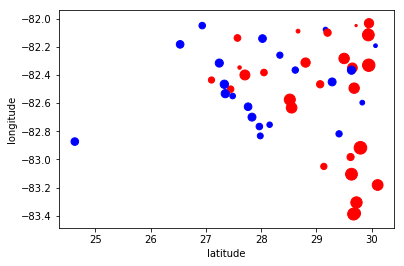

In [36]:
%matplotlib inline
sizes = np.array(pdf['avg(coeff_1)'])
colors = ['red' if x<0 else 'blue' for x in sizes]
pdf.plot.scatter(x='latitude',y='longitude', s=np.power(np.abs(sizes),0.7), c = colors);

In [27]:
np.array(pdf['avg(coeff_1)'])+1400

array([  547.07117097,     6.07073437,  1541.64068901,  1185.90768617,
        1600.98651061,  1354.54298475,  1731.98138269,  1209.64681624,
        1616.60144535,  1561.57762255,   240.4084064 ,  1727.33945255,
        1171.86761731,   742.58878731,  1804.82516038,   593.53734634,
        1484.97903662,   820.74358773,    69.94049944,   506.86310987,
        1390.2379655 ,   580.09063148,  1767.74762156,  1793.84332822,
        1481.80372986,  1105.58629651,  1125.60638861,  1365.00165178,
        1771.79792812,  1740.39810444,  1614.95149156,  1442.21311873,
        1109.74905056,  1586.63459058,  1808.14368391,  1827.48752794,
         216.47308322,  1052.54903528,   252.35422171,   822.30522045,
         370.75676965,   514.05622969,   694.30059848,  1530.38666643,
        1176.19928233,  1591.15350395,  1217.26611523,   444.3826722 ,
        1730.69209725])

In [ ]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()